# Packages & functions

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow.keras import models

from tensorflow.keras.layers import Conv2D as Conv2D
from tensorflow.keras.layers import BatchNormalization as BatchNormalization
from tensorflow.keras.layers import ReLU as ReLU
from tensorflow.keras.layers import MaxPool2D as MaxPool2D
from tensorflow.keras.layers import Flatten as Flatten
from tensorflow.keras.layers import Dense as Dense

from os.path import isdir
import os
import numpy as np

from sklearn.model_selection import train_test_split

# Plotting
import seaborn as sns

In [4]:
class DataProperties:
    data_path = '/content/drive/MyDrive/UNIPD/HDA/Project/Data/'
    covid_path = data_path + 'covid/'
    pneumonia_path = data_path + 'pneumonia/'
    healthy_path = data_path + 'normal/'

    healthy_class = 0
    covid_class = 1
    pneumonia_class = 2

class TrainParameters:
    train_size = 0.8
    random_state = 123
    batch_size = 32
    max_size = 50  # Max size of each class

class PreprocParameters:
    resize_shape = (300, 300)

# Data download

## Paths download

In [5]:
# Load filenames
def load_filenames(data_path, max_files = None):
    p = os.listdir(data_path)
    if max_files is not None:
        p = p[: min(max_files, len(p))]
    p = [data_path + file_path for file_path in p]
    return p

In [6]:
covid_fnames = load_filenames(DataProperties.covid_path, TrainParameters.max_size)
pn_fnames = load_filenames(DataProperties.pneumonia_path, TrainParameters.max_size)
healthy_fnames = load_filenames(DataProperties.healthy_path, TrainParameters.max_size)

In [7]:
covid_labels = np.full(
    len(covid_fnames), fill_value = DataProperties.covid_class
)

pn_labels = np.full(
    len(pn_fnames), fill_value = DataProperties.pneumonia_class
)

healthy_labels = np.full(
    len(healthy_fnames), fill_value = DataProperties.healthy_class
)

In [8]:
X = [
     *covid_fnames, *pn_fnames, *healthy_fnames
]

Y = [
     *covid_labels, *pn_labels, *healthy_labels
]

## Split

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    train_size = TrainParameters.train_size,
    random_state = TrainParameters.random_state,
    stratify = Y
)

# Data exploration

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


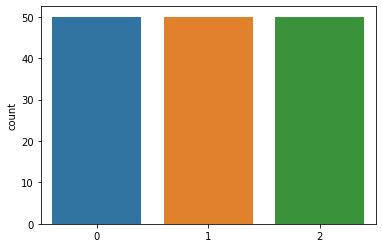

In [10]:
_ = sns.countplot(Y)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


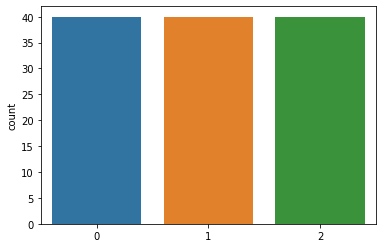

In [11]:
_ = sns.countplot(Y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


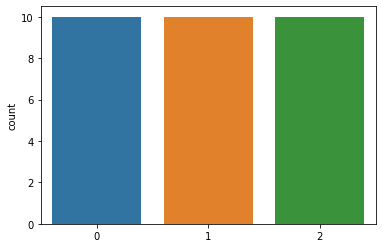

In [12]:
_ = sns.countplot(Y_test)

In [13]:
def load_image(full_path):
    print(f'Loading, {full_path}')
    img = cv2.imread(full_path, cv2.IMREAD_COLOR)
    print(type(img))
    return img

/content/drive/MyDrive/UNIPD/HDA/Project/Data/covid/COVID-19 (401).jpg
Loading, /content/drive/MyDrive/UNIPD/HDA/Project/Data/covid/COVID-19 (401).jpg
<class 'numpy.ndarray'>


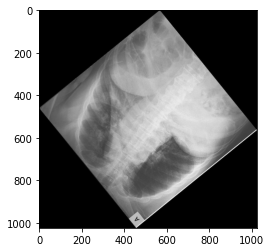

In [14]:
print(X[0])
im = load_image(X[0])
plt.imshow(im.astype('uint8'))

Loading, /content/drive/MyDrive/UNIPD/HDA/Project/Data/covid/COVID-19 (527).jpg
<class 'numpy.ndarray'>


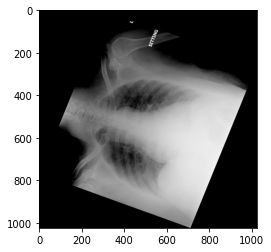

In [15]:
im = load_image(X_train[0])
plt.imshow(im.astype('uint8'))

# Creating dataset

In [16]:
img_height, img_width = PreprocParameters.resize_shape 
batch_size = 4
seed = 123
validation_split = 0.2
shuffle_train = True
shuffle_test = True

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    DataProperties.data_path,
    labels = 'inferred',
    label_mode = 'int',
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = shuffle_train,
    seed = seed,
    validation_split = validation_split,
    subset = 'training'
)

ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    DataProperties.data_path,
    labels = 'inferred',
    label_mode = 'int',
    # class_names = ,
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = shuffle_test,
    seed = seed,
    validation_split = validation_split,
    subset = 'validation'
)

Found 4575 files belonging to 3 classes.
Using 3660 files for training.
Found 4575 files belonging to 3 classes.
Using 915 files for validation.


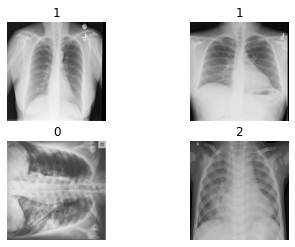

In [17]:
for images, labels in ds_train.take(1):
    for i in range(batch_size):
        ax = plt.subplot(np.sqrt(batch_size), np.sqrt(batch_size), i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str(labels[i].numpy()))
        plt.axis("off")

In [18]:
def print_max_pix_val(ds):
    for images, labels in ds.take(1):
        for i in range(batch_size):
            print(np.max(images[i].numpy()))
            print(images[i].numpy().shape)

print_max_pix_val(ds_train)
print_max_pix_val(ds_validation)

252.60275
(300, 300, 3)
255.0
(300, 300, 3)
250.94814
(300, 300, 3)
255.0
(300, 300, 3)
249.80574
(300, 300, 3)
252.22665
(300, 300, 3)
250.67702
(300, 300, 3)
254.496
(300, 300, 3)


# Data preprocessing

## Normalization

In [19]:
def normalize_image(image, y):
    return tf.cast(image, tf.float32) / 255., y

In [20]:
ds_train = ds_train.map(normalize_image)
ds_validation = ds_validation.map(normalize_image)

print_max_pix_val(ds_train)
print_max_pix_val(ds_validation)

0.9997136
(300, 300, 3)
1.0
(300, 300, 3)
1.0
(300, 300, 3)
0.9937647
(300, 300, 3)
1.0
(300, 300, 3)
1.0
(300, 300, 3)
0.9985647
(300, 300, 3)
1.0
(300, 300, 3)


# CNN

In [21]:
# model = models.Sequential()
# model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (300, 300, 3)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64, (3,3), activation = 'relu')
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64, (3,3), activation = 'relu')

model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(3))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 322624)            0

In [23]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [25]:
history = model.fit(
    ds_train,  # ds_validation,
    epochs = 10,
    verbose = 2
)

Epoch 1/10
229/229 - 109s - loss: 0.6094 - accuracy: 0.7956 - 109s/epoch - 478ms/step
Epoch 2/10
229/229 - 13s - loss: 0.4155 - accuracy: 0.8623 - 13s/epoch - 58ms/step
Epoch 3/10
229/229 - 14s - loss: 0.2848 - accuracy: 0.8842 - 14s/epoch - 59ms/step
Epoch 4/10
229/229 - 13s - loss: 0.1803 - accuracy: 0.9213 - 13s/epoch - 58ms/step
Epoch 5/10
229/229 - 14s - loss: 0.1459 - accuracy: 0.9519 - 14s/epoch - 59ms/step
Epoch 6/10
229/229 - 14s - loss: 0.0970 - accuracy: 0.9672 - 14s/epoch - 60ms/step
Epoch 7/10
229/229 - 14s - loss: 0.1293 - accuracy: 0.9617 - 14s/epoch - 59ms/step
Epoch 8/10
229/229 - 14s - loss: 0.0327 - accuracy: 0.9923 - 14s/epoch - 59ms/step
Epoch 9/10
229/229 - 14s - loss: 0.0547 - accuracy: 0.9847 - 14s/epoch - 59ms/step
Epoch 10/10
229/229 - 14s - loss: 0.0381 - accuracy: 0.9880 - 14s/epoch - 60ms/step


In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

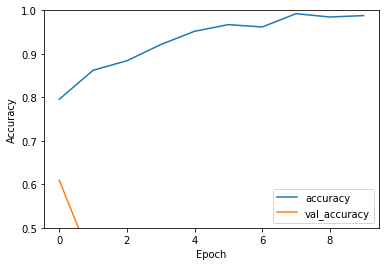

In [29]:
plt.plot(history.history['accuracy'], label='accuracy')

plt.plot(history.history['loss'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
test_loss, test_acc = model.evaluate(ds_validation, verbose = 2)  # (ds_train, verbose=2)
print(test_acc)

## Other stuff

In [ ]:
def LOAD_IMAGE(full_path):
    print(f'Loading, {full_path}')
    file = tf.io.read_file(full_path)
    extension = full_path[-3:]
    if extension == 'jpg':
        image_decoded = tf.io.decode_jpeg(file, channels=3)
        image = tf.cast(image_decoded, tf.float32)
        
    if extension == 'png':
        image_decoded = tf.io.decode_jpeg(file, channels=3)
        image = tf.cast(image_decoded, tf.float32)
    else:
        image_decoded = tf.io.decode_jpeg(file, channels=3)
        image = tf.cast(image_decoded, tf.float32)
    return image

def resize_image(image, new_shape):
    n = cv2.resize(image, new_shape)
    return n

def normalize_image(image):
    return tf.cast(image, tf.float32) / 255.


def create_dataset(file_names, shuffle, cache_file):
    dataset = tf.data.Dataset.from_tensor_slices(
        file_names
    )

    # load image func
    load_im = lambda full_path: (
        tf.numpy_function(LOAD_IMAGE, [full_path], tf.float32)
    )

    # # resize
    # resize_im = lambda image: (
    #     tf.numpy_function(
    #         resize_image, 
    #         [image, PreprocParameters.resize_shape], 
    #         tf.float32
    #     )
    # )

    # # normalize
    # normalize_im = lambda image: (
    #     tf.numpy_function(
    #         normalize_image,
    #         [image],
    #         tf.float32
    #     )
    # )

    dataset = dataset.map(load_im, num_parallel_calls = os.cpu_count())
    # dataset = dataset.map(resize_im, num_parallel_calls = os.cpu_count())
    # dataset = dataset.map(normalize_im, num_parallel_calls = os.cpu_count())

    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)

    # Shuffle
    #if shuffle:
    #    dataset = dataset.shuffle(len(file_names))

    # Repeat the dataset indefinitely
    # dataset = dataset.repeat()

    # Batch
    # dataset = dataset.batch(
     #   batch_size = TrainParameters.batch_size
    #)

    # Prefetch
    #dataset = dataset.prefetch(buffer_size = 1)

    return dataset

In [ ]:
train_dataset = create_dataset(
    X_train,
    shuffle = True,
    cache_file = None # 'train_cache'
)

test_dataset = create_dataset(
    X_test,
    shuffle = True,
    cache_file = None # 'test_cache'
)

# CNN model

In [ ]:
train_dataset.take(2)

<TakeDataset shapes: <unknown>, types: tf.float32>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/covid/COVID-19 (527).jpg'
Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/normal/00000419_000.png'
Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/covid/COVID-19 (408).jpg'
Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/normal/00000366_001.png'
Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/normal/00000370_007.png'
Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/pneumonia/person1313_bacteria_3320.jpeg'
Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/normal/00000427_001.png'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


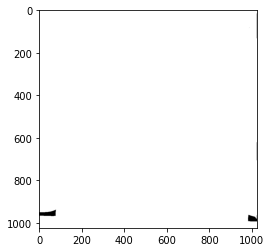

In [ ]:
for im in train_dataset.take(5):
    plt.imshow(im)